# NPM : 5220411257
# NAMA : Zahfar Aziz Ferdian

## Eksperimen 1
## Proses Lematisasi, WORD2VEC, LSTM

In [8]:
!pip install Sastrawi

In [9]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 61.9 MB/s eta 0:00:00


In [10]:
# ==========================================
# 1. INSTALASI LIBRARY (Jalankan sekali saja)
# ==========================================

import pandas as pd
import numpy as np
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# ==========================================
# 2. LOAD DATA
# ==========================================
# Pastikan file 'Data_Manual.csv' sudah diupload ke sesi Colab/Folder Anda
df = pd.read_csv('Data_Manual.csv')
print("Contoh data awal:")
print(df.head())

# ==========================================
# 3. PREPROCESSING (CLEANING + LEMATISASI)
# ==========================================
# Inisialisasi Stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess_text(text):
    # A. Cleaning Standar
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # B. Lematisasi (Sastrawi)
    # Mengubah kata berimbuhan menjadi kata dasar (misal: "membeli" -> "beli")
    text = stemmer.stem(text)

    return text

print("\nSedang memproses teks (ini mungkin memakan waktu)...")
df['clean_text'] = df['text'].apply(preprocess_text)
print("Preprocessing selesai!")
print(df[['text', 'clean_text']].head())

# ==========================================
# 4. EKSTRAKSI FITUR WORD2VEC
# ==========================================
# Siapkan data untuk Word2Vec (list of lists of words)
sentences = [text.split() for text in df['clean_text']]

# Latih Model Word2Vec
# vector_size=100: dimensi vektor
# window=5: jarak pandang kata
# min_count=1: abaikan kata yang muncul kurang dari 1 kali
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
print(f"\nWord2Vec selesai dilatih. Ukuran vocab: {len(w2v_model.wv.key_to_index)}")

# ==========================================
# 5. PERSIAPAN DATA UNTUK LSTM
# ==========================================
# Tokenisasi
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
X = tokenizer.texts_to_sequences(df['clean_text'])
vocab_size = len(tokenizer.word_index) + 1

# Padding (menyamakan panjang input)
max_length = 100
X = pad_sequences(X, maxlen=max_length)

# Label Encoding
le = LabelEncoder()
y = le.fit_transform(df['label'])
y = to_categorical(y) # One-hot encoding

# Membuat Embedding Matrix dari bobot Word2Vec
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        # Jika kata tidak ada di Word2Vec (jarang terjadi), inisialisasi random
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 6. MEMBANGUN MODEL LSTM
# ==========================================
model = Sequential()
# Load bobot Word2Vec ke dalam layer Embedding dan set trainable=False (Static)
# atau True jika ingin fine-tuning
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax')) # 3 output: Positif, Negatif, Netral

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# ==========================================
# 7. TRAINING
# ==========================================
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluasi
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'\nFinal Test Accuracy: {accuracy*100:.2f}%')

Contoh data awal:
                                                text    label
0   "Toyota Vios Gen 4:\n🤫ssssssttt!!!! (suara diam)  positif
1  Vios adalah versi sedan dari Veloz krn dasborn...  positif
2  Radius putarnya masih boros gak ya...kayak vio...  negatif
3            Iya, mungkin tahun ini atau tahun depan  negatif
4  @HAEMEN4  ngapain beli toyota bro, mending bel...  negatif

Sedang memproses teks (ini mungkin memakan waktu)...
Preprocessing selesai!
                                                text  \
0   "Toyota Vios Gen 4:\n🤫ssssssttt!!!! (suara diam)   
1  Vios adalah versi sedan dari Veloz krn dasborn...   
2  Radius putarnya masih boros gak ya...kayak vio...   
3            Iya, mungkin tahun ini atau tahun depan   
4  @HAEMEN4  ngapain beli toyota bro, mending bel...   

                                          clean_text  
0               toyota vios gen ssssssttt suara diam  
1  vios adalah versi sedan dari veloz krn dasbor ...  
2  radius putar masih boros gak

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │        87,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,900 (343.36 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 87,900 (343.36 KB)

None
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.3949 - loss: 1.0952 - val_accuracy: 0.4000 - val_loss: 1.0754
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.4399 - loss: 1.0711 - val_accuracy: 0.4000 - val_loss: 1.0471
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.3631 - loss: 1.0757 - val_accuracy: 0.4000 - val_loss: 1.0609
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.4342 - loss: 1.0528 - val_accuracy: 0.4000 - val_loss: 1.0555
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.3848 - loss: 1.0606 - val_accuracy: 0.4000 - val_loss: 1.0499
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3601 - loss: 1.0678 - val_accuracy: 0.4000 - val_loss: 1.0427
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.3997 - loss: 1.0819 - val_accuracy: 0.4000 - val_loss: 1.0424
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.4257 - loss: 1.0653 - val_accuracy: 0.4000 - val_

## Eksperimen 2
## Proses Steaming, WORD2VEC, LSTM

In [11]:
df = pd.read_csv('Data_Manual.csv')

# Inisialisasi Stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def cleaning_and_stemming(text):
    # A. Cleaning Standar
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # B. Proses Stemming (Sastrawi)
    # Mengubah kata berimbuhan menjadi kata dasar
    # Contoh: "membelikan" -> "beli", "dimakan" -> "makan"
    text = stemmer.stem(text)

    return text

print("Sedang melakukan proses Stemming ")
df['clean_text'] = df['text'].apply(cleaning_and_stemming)
print("Stemming selesai!")

# Tokenisasi manual untuk input Word2Vec
sentences = [text.split() for text in df['clean_text']]

# Latih Word2Vec
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Tokenisasi Keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
X = tokenizer.texts_to_sequences(df['clean_text'])
vocab_size = len(tokenizer.word_index) + 1

# Padding
max_length = 100
X = pad_sequences(X, maxlen=max_length)

# Encoding Label
le = LabelEncoder()
y = le.fit_transform(df['label'])
y = to_categorical(y)

# Buat Embedding Matrix dari Word2Vec untuk bobot awal LSTM
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model LSTM

model = Sequential()
# Menggunakan bobot dari Word2Vec (weights=[embedding_matrix])
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'\nFinal Test Accuracy: {accuracy*100:.2f}%')

Sedang melakukan proses Stemming 
Stemming selesai!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │        87,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,900 (343.36 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 87,900 (343.36 KB)

None
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.4151 - loss: 1.0962 - val_accuracy: 0.4200 - val_loss: 1.0844
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.3764 - loss: 1.0908 - val_accuracy: 0.5200 - val_loss: 1.0800
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.4747 - loss: 1.0761 - val_accuracy: 0.4600 - val_loss: 1.0581
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.4345 - loss: 1.0704 - val_accuracy: 0.4000 - val_loss: 1.0415
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - accuracy: 0.4581 - loss: 1.0558 - val_accuracy: 0.4000 - val_loss: 1.0514
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4307 - loss: 1.0581 - val_accuracy: 0.4600 - val_loss: 1.0575
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4280 - loss: 1.0589 - val_accuracy: 0.5000 - val_loss: 1.0506
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4015 - loss: 1.0579 - val_accuracy: 0.4200 - val_

## Eksperimen 3
## Proses Lematisasi, TF-IDF, XBoost

In [12]:
!pip install Sastrawi xgboost

Sedang melakukan preprocessing & lematisasi
Selesai!

Mapping Label:
negatif -> 0
netral -> 1
positif -> 2

Sedang melatih model XGBoost...

✅ Akurasi Model XGBoost: 72.00%

Laporan Klasifikasi Lengkap:
              precision    recall  f1-score   support

     negatif       0.67      0.95      0.78        21
      netral       0.67      0.22      0.33         9
     positif       0.82      0.70      0.76        20

    accuracy                           0.72        50
   macro avg       0.72      0.62      0.62        50
weighted avg       0.73      0.72      0.69        50



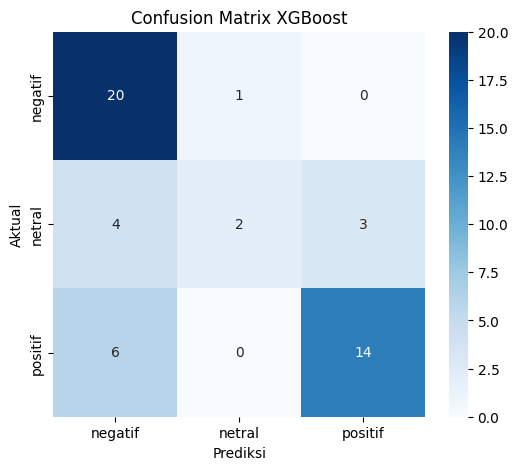

In [16]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier

df = pd.read_csv('Data_Manual.csv')

# Inisialisasi Sastrawi (Stemmer/Lemmatizer)
factory = StemmerFactory()
lemmatizer = factory.create_stemmer()

def text_lemmatization(text):
    # A. Cleaning Dasar
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # B. Lematisasi (Mengubah ke kata dasar)
    text = lemmatizer.stem(text)

    return text

print("Sedang melakukan preprocessing & lematisasi")
df['clean_text'] = df['text'].apply(text_lemmatization)
print("Selesai!")


# XGBoost mewajibkan label berupa angka (0, 1, 2)
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

print("\nMapping Label:")
for i, label in enumerate(le.classes_):
    print(f"{label} -> {i}")

tfidf = TfidfVectorizer(max_features=1000)

X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['label_encoded']

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nSedang melatih model XGBoost...")
# n_estimators=100: Jumlah 'pohon' keputusan
# learning_rate=0.1: Kecepatan belajar
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='mlogloss' # Metric untuk multi-class classification
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Akurasi Model XGBoost: {accuracy*100:.2f}%")

print("\nLaporan Klasifikasi Lengkap:")
# Mengembalikan label angka ke label asli (Positif/Negatif/Netral) untuk laporan
target_names = [str(cls) for cls in le.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))

# Menampilkan Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix XGBoost')
plt.show()


## Eksperimen 4
## Proses Lematisasi, TF-IDF, Logistic Regression

Sedang melakukan preprocessing & lematisasi...
Preprocessing selesai!
Mapping Label: {0: 'negatif', 1: 'netral', 2: 'positif'}

Sedang melatih Logistic Regression...

✅ Akurasi Logistic Regression: 66.00%

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.62      0.95      0.75        21
      netral       1.00      0.11      0.20         9
     positif       0.71      0.60      0.65        20

    accuracy                           0.66        50
   macro avg       0.78      0.55      0.53        50
weighted avg       0.72      0.66      0.61        50



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


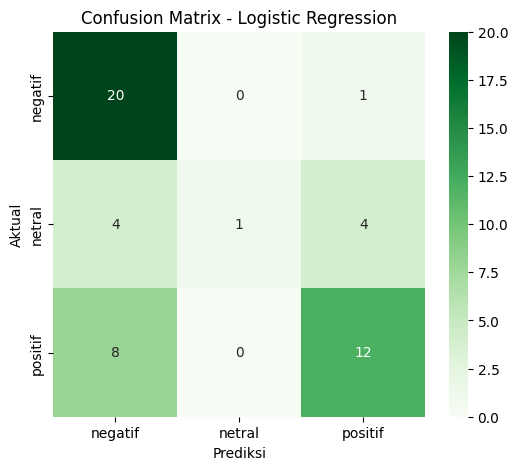


Menampilkan kata-kata paling berpengaruh untuk setiap label:


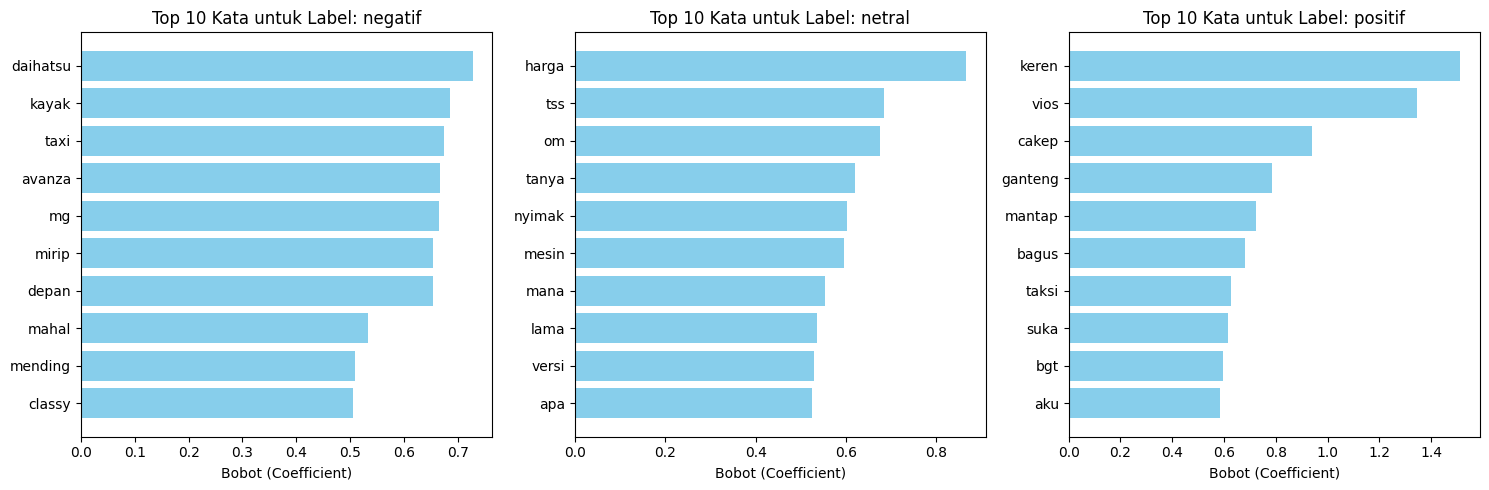

In [14]:
# ==========================================
# 1. INSTALASI LIBRARY
# ==========================================
# !pip install Sastrawi

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ==========================================
# 2. LOAD DATA & PREPROCESSING (LEMATISASI)
# ==========================================
df = pd.read_csv('Data_Manual.csv')

# Inisialisasi Sastrawi
factory = StemmerFactory()
lemmatizer = factory.create_stemmer()

def text_lemmatization(text):
    # Cleaning
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Lematisasi
    text = lemmatizer.stem(text)
    return text

print("Sedang melakukan preprocessing & lematisasi...")
df['clean_text'] = df['text'].apply(text_lemmatization)
print("Preprocessing selesai!")

# ==========================================
# 3. LABEL ENCODING
# ==========================================
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
labels_map = {i: label for i, label in enumerate(le.classes_)}
print(f"Mapping Label: {labels_map}")

# ==========================================
# 4. EKSTRAKSI FITUR: TF-IDF
# ==========================================
# Kita ambil 5000 kata teratas
tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['label_encoded']

# Split Data (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 5. TRAINING MODEL (LOGISTIC REGRESSION)
# ==========================================
print("\nSedang melatih Logistic Regression...")

# max_iter=1000 sangat penting untuk data teks agar model 'converge' (selesai belajar)
model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', multi_class='auto')
model.fit(X_train, y_train)

# ==========================================
# 6. EVALUASI MODEL
# ==========================================
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Akurasi Logistic Regression: {accuracy*100:.2f}%")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

# ==========================================
# 7. BONUS: MELIHAT KATA KUNCI TERPENTING
# ==========================================
# Salah satu kelebihan Logistic Regression adalah kita bisa melihat 'koefisien' kata.
# Kode ini akan menampilkan kata-kata yang paling mencirikan Positif vs Negatif.

def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()

    for i, label in enumerate(le.classes_):
        # Ambil koefisien untuk kelas tertentu
        # Untuk multiclass, model.coef_ bentuknya (n_classes, n_features)
        coefs = model.coef_[i]

        # Urutkan index dari nilai koefisien terbesar
        top_positive_coefficients = np.argsort(coefs)[-n_top_words:]

        # Ambil nama kata dan nilainya
        top_words = [feature_names[j] for j in top_positive_coefficients]
        top_coefs = coefs[top_positive_coefficients]

        # Plot
        axes[i].barh(top_words, top_coefs, color='skyblue')
        axes[i].set_title(f"Top 10 Kata untuk Label: {label}")
        axes[i].set_xlabel("Bobot (Coefficient)")

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
print("\nMenampilkan kata-kata paling berpengaruh untuk setiap label:")
plot_top_words(model, tfidf.get_feature_names_out())

Tabel Perbandingan Akurasi:
                                Eksperimen  Akurasi
0        Eksperimen 1\n(Lema + W2V + LSTM)     54.0
1        Eksperimen 2\n(Stem + W2V + LSTM)     42.0
2  Eksperimen 3\n(Lema + TF-IDF + XGBoost)     72.0
3   Eksperimen 4\n(Lema + TF-IDF + LogReg)     66.0
------------------------------


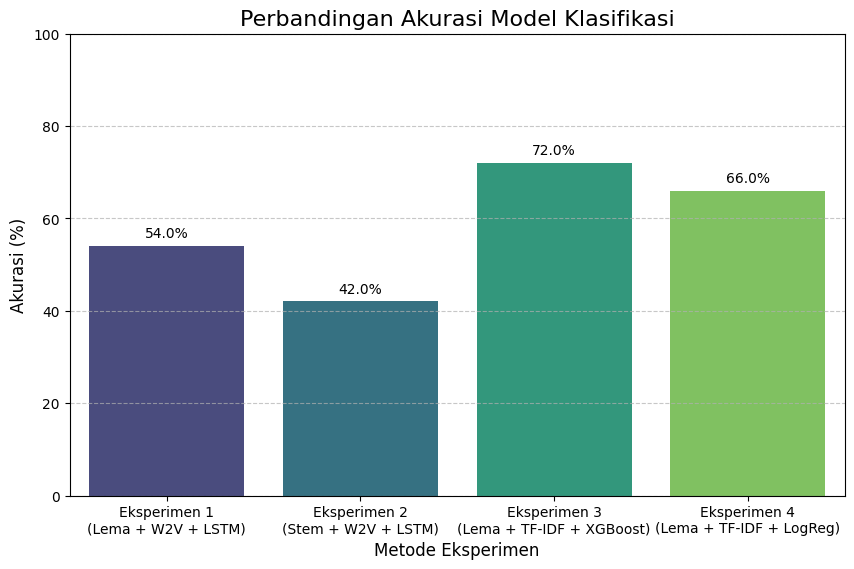


KESIMPULAN:
Model terbaik adalah Eksperimen 3 (Lema + TF-IDF + XGBoost) dengan akurasi 72.0%.


In [18]:
# ==========================================\n
# PERBANDINGAN HASIL AKURASI
# ==========================================\n
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat Dataframe hasil akurasi berdasarkan output eksperimen di atas
data_hasil = {
    'Eksperimen': [
        'Eksperimen 1\n(Lema + W2V + LSTM)',
        'Eksperimen 2\n(Stem + W2V + LSTM)',
        'Eksperimen 3\n(Lema + TF-IDF + XGBoost)',
        'Eksperimen 4\n(Lema + TF-IDF + LogReg)'
    ],
    'Akurasi': [54.00, 42.00, 72.00, 66.00] # Nilai diambil dari output run sebelumnya
}

df_hasil = pd.DataFrame(data_hasil)

# Menampilkan Tabel
print("Tabel Perbandingan Akurasi:")
print(df_hasil)
print("-" * 30)

# Membuat Visualisasi Bar Chart
plt.figure(figsize=(10, 6))
plot = sns.barplot(x='Eksperimen', y='Akurasi', data=df_hasil, hue='Eksperimen', palette='viridis', legend=False)

# Menambahkan label angka di atas batang
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.1f') + '%',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.title('Perbandingan Akurasi Model Klasifikasi', fontsize=16)
plt.ylabel('Akurasi (%)', fontsize=12)
plt.xlabel('Metode Eksperimen', fontsize=12)
plt.ylim(0, 100) # Set batas y dari 0 sampai 100
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Kesimpulan Otomatis
best_model = df_hasil.loc[df_hasil['Akurasi'].idxmax()]
print(f"\nKESIMPULAN:")
print(f"Model terbaik adalah {best_model['Eksperimen'].replace(chr(10), ' ')} dengan akurasi {best_model['Akurasi']}%.")